### Common import and load the null and actul importance distributions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import lightgbm as lgb


import warnings
warnings.simplefilter('ignore', UserWarning)


DIR = "../dataset/"

data_x = pd.read_csv(DIR + "data_X.csv", decimal=',')
data_y = pd.read_csv(DIR + "data_Y.csv", decimal=',')
submit_y = pd.read_csv(DIR+'sample_submission.csv', sep=',')
print(data_x.columns, data_y.columns, submit_y.columns)
print(len(data_x), len(data_y), len(submit_y))

train_df = data_x.merge(data_y, left_on='date_time', right_on='date_time')
test_df = data_x.merge(submit_y, left_on='date_time', right_on='date_time').drop("quality", axis=1)

train_df.drop("date_time", axis=1, inplace=True)
train_df["H_data"] = train_df["H_data"].astype("float")
train_df["AH_data"] = train_df["AH_data"].astype("float")
train_df["2_hours_before"] = [train_df["quality"].mean()]*2 + train_df["quality"][:-2].values.tolist()


actual_imp_df = pd.read_csv(DIR + "actual_importances_distribution_rf.csv")
null_imp_df = pd.read_csv(DIR + "null_importances_distribution_rf.csv")

Index(['date_time', 'T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1',
       'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3',
       'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'T_data_5_1', 'T_data_5_2',
       'T_data_5_3', 'H_data', 'AH_data'],
      dtype='object') Index(['date_time', 'quality'], dtype='object') Index(['date_time', 'quality'], dtype='object')
2103841 29184 5808


### Display the distributions

In [2]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(),
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of column %s' % feature_, fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for column %s ' % feature_)
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(),
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of column %s' % feature_, fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for column %s ' % feature_)

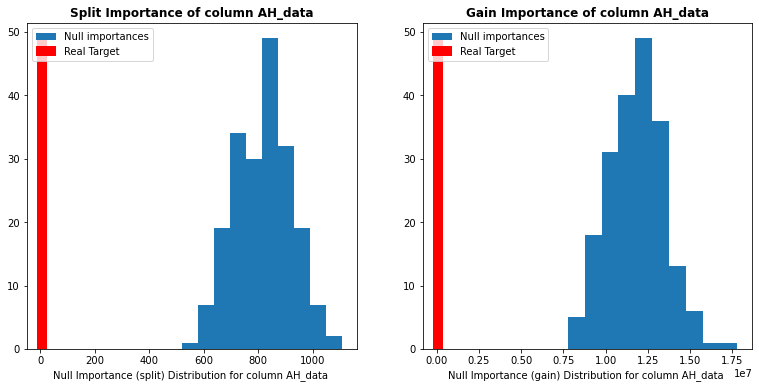

In [3]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='AH_data')

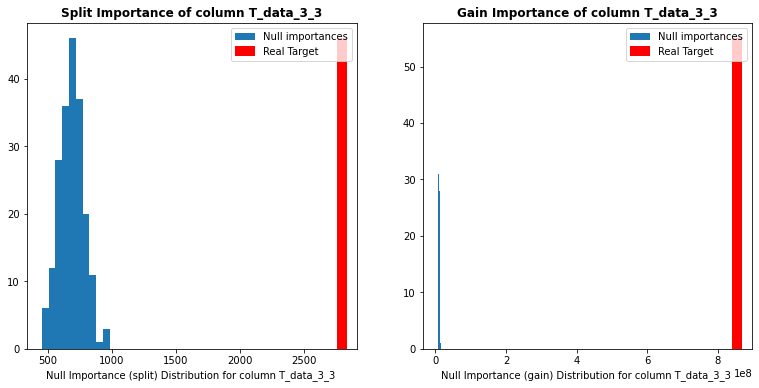

In [4]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='T_data_3_3')

From the above plot, we can know that there are usually complex relations between industrial data. For any feature with large variance, the tree-based model can always find the split point to optimize the loss function, which causes a deviation in the ranking of feature importance.

### Score features

We can use the log actual feature importance divided by the 75 percentile of null distribution

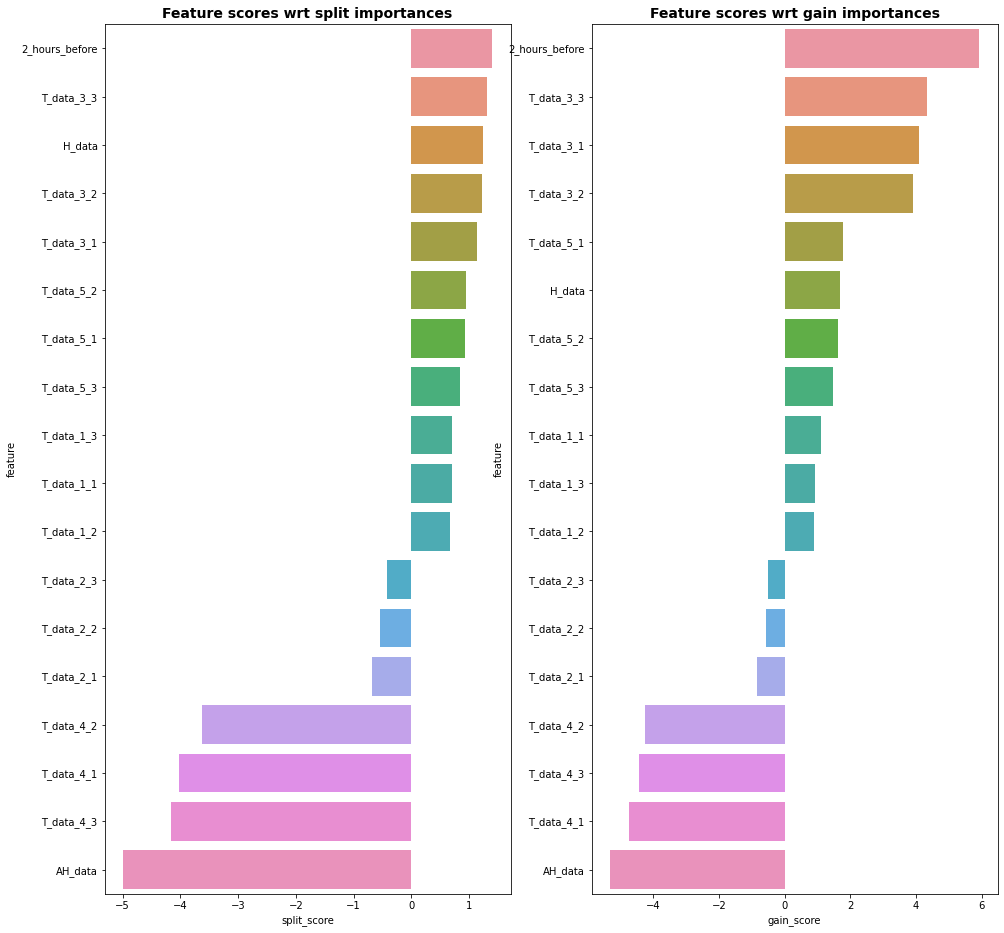

<Figure size 432x288 with 0 Axes>

In [5]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
df1 = scores_df.sort_values('split_score', ascending=False)
sns.barplot(x='split_score', y='feature', data=df1.iloc[0:30], order=df1["feature"].iloc[:30], ax=ax, orient='h')
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
df2 = scores_df.sort_values('gain_score', ascending=False)
sns.barplot(x='gain_score', y='feature', data=df2.iloc[0:30], order=df2["feature"].iloc[:30], ax=ax, orient='h')
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.show()
plt.tight_layout()

We see that not all features are of high importance

Also We use a different metric to asses correlation to the target. 

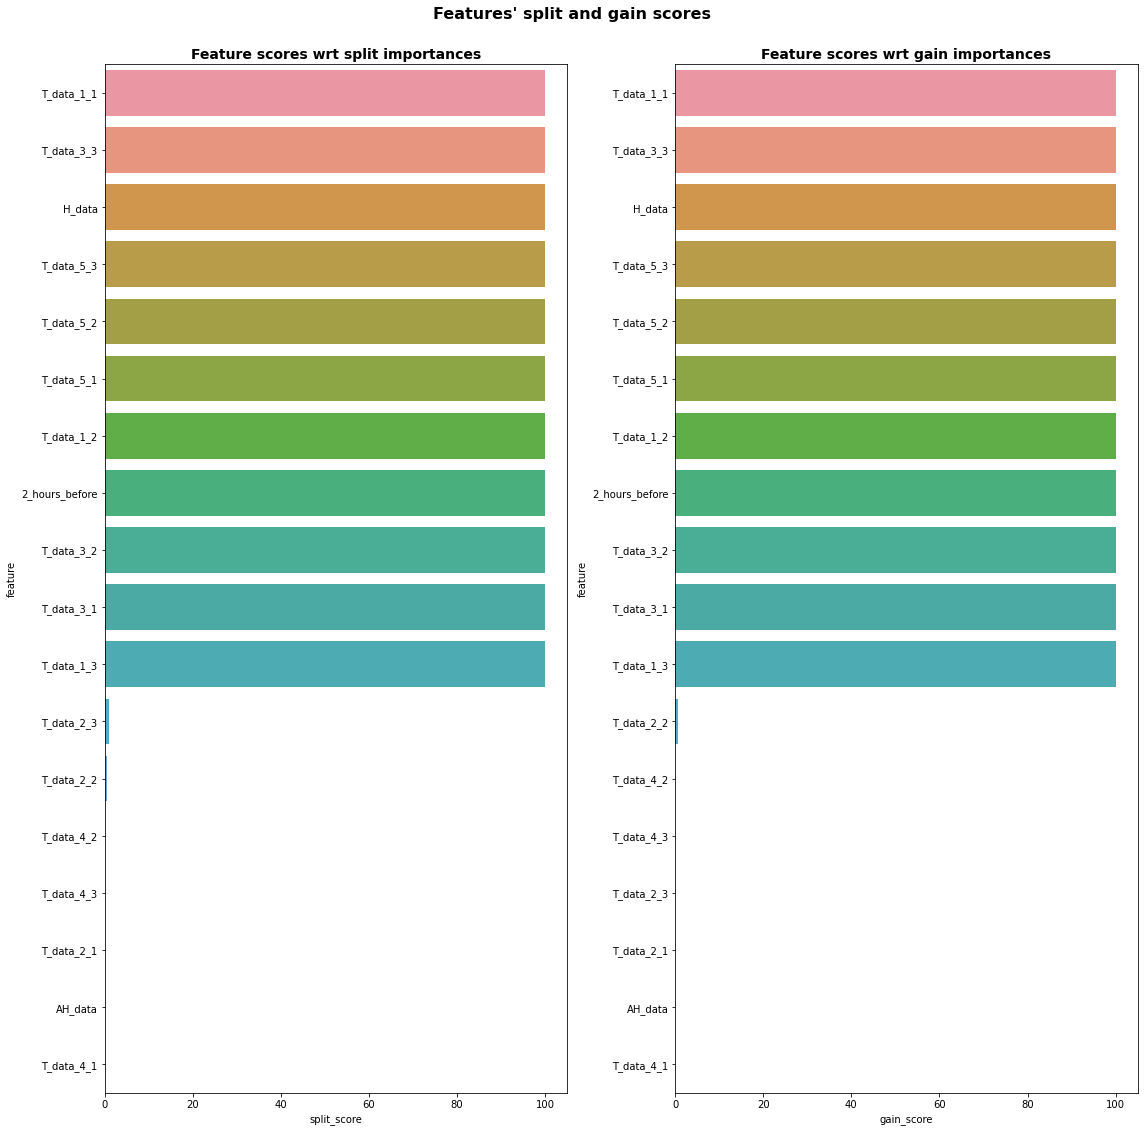

In [6]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)
plt.show()

### Score feature removal for different thresholds

In [7]:
def score_feature_selection(df=None, train_features=None, target=None):
    # Fit LightGBM
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'seed': 13,
        'n_jobs': 4,
    }

    # Fit the model
    hist = lgb.cv(
        params=lgb_params,
        train_set=dtrain,
        num_boost_round=2000,
        nfold=5,
        shuffle=False,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17,
        stratified=False
    )

    return hist['l2-mean'][-1], hist['l2-stdv'][-1]


threshold_lis = [0, 0.4, 99]

for threshold in threshold_lis:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]

    print('Results for threshold %0.1f' % threshold)
    split_results = score_feature_selection(df=train_df, train_features=split_feats,
                                            target=train_df['quality'].values)
    print('\t %d features SPLIT : %.6f +/- %.6f' % (len(split_feats), split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=train_df, train_features=gain_feats,
                                           target=train_df['quality'].values)
    print('\t %d features GAIN  : %.6f +/- %.6f' % (len(gain_feats), gain_results[0], gain_results[1]))

Results for threshold 0.0
	 18 features SPLIT : 118.670876 +/- 4.919677
	 18 features GAIN  : 118.670876 +/- 4.919677
Results for threshold 0.4
	 13 features SPLIT : 117.947205 +/- 4.577466
	 12 features GAIN  : 119.819859 +/- 5.225399
Results for threshold 99.0
	 11 features SPLIT : 132.592124 +/- 5.908403
	 11 features GAIN  : 132.592124 +/- 5.908403


In [8]:
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= 0.4]
print(split_feats)

['T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3', 'T_data_5_1', 'T_data_5_2', 'T_data_5_3', 'H_data', '2_hours_before']
